In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "TCP"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn004651,MEVEEIQNQGCKFPRISNGRGDLTKIGQKGEDQYQEDEKDGEVKRG...,420,1
1,Achn033791,MYPFNTNGNLISYTLYNPNSKQDHPPPPSSLSYFPSPPYIPYEDDD...,404,1
2,Achn033961,MYPSNTNGNLISYTLYDYDLNNANSKQDYHPPIPPPLSSISYFPSP...,322,1
3,Achn039311,MSITENNNNNNKNKPQEIKDLQIVIADKEEASKKQLAPKRSSNKDR...,249,1
4,Achn039821,MYPSSNNDNTPITYPSLDQTICFKSSLYDDFTSNSTQDQDPQSSSL...,324,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
6030,0.004866,0.002433,0.007299,0.002433,0.002433,0.004866,0.000000,0.004866,0.002433,0.004866,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.002433,0.0,0.0,0.000000
139,0.008889,0.000000,0.004444,0.008889,0.000000,0.000000,0.000000,0.004444,0.000000,0.000000,...,0.013333,0.000000,0.000000,0.004444,0.0,0.004444,0.004444,0.0,0.0,0.004444
3983,0.019093,0.000000,0.004773,0.007160,0.000000,0.009547,0.002387,0.002387,0.002387,0.007160,...,0.000000,0.000000,0.000000,0.002387,0.0,0.000000,0.000000,0.0,0.0,0.000000
4488,0.015198,0.003040,0.003040,0.012158,0.006079,0.003040,0.000000,0.009119,0.003040,0.012158,...,0.000000,0.006079,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
5556,0.003268,0.003268,0.003268,0.006536,0.003268,0.000000,0.003268,0.000000,0.009804,0.003268,...,0.000000,0.000000,0.003268,0.003268,0.0,0.000000,0.000000,0.0,0.0,0.000000


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (6676, 441)
X_test: (1669, 441)
y_train: (6676,)
y_test: (1669,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 38s 467ms/step - accuracy: 0.4375 - loss: 0.6934

33/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6246 - loss: 0.6830   

66/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7072 - loss: 0.6309

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7363 - loss: 0.5904 - val_accuracy: 0.9708 - val_loss: 0.1044


Epoch 2/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0704

32/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9722 - loss: 0.0933

62/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9750 - loss: 0.0870

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9758 - loss: 0.0837 - val_accuracy: 0.9790 - val_loss: 0.0663


Epoch 3/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0486

31/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9883 - loss: 0.0474

62/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9866 - loss: 0.0510

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9857 - loss: 0.0528 - val_accuracy: 0.9768 - val_loss: 0.0680


Epoch 4/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0479

31/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9855 - loss: 0.0581

61/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9879 - loss: 0.0478

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9887 - loss: 0.0446 - val_accuracy: 0.9813 - val_loss: 0.0559


Epoch 5/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0172

31/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0214

61/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0247

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0263 - val_accuracy: 0.9873 - val_loss: 0.0512


Epoch 6/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0165

32/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9921 - loss: 0.0261

63/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9921 - loss: 0.0270

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.0268 - val_accuracy: 0.9880 - val_loss: 0.0458


Epoch 7/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0036

30/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0200

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0192

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0193 - val_accuracy: 0.9701 - val_loss: 0.0944


Epoch 8/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.0678

32/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9844 - loss: 0.0355

63/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9884 - loss: 0.0302

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0296 - val_accuracy: 0.9895 - val_loss: 0.0463


Epoch 9/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0051

33/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0137

65/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0160

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0169 - val_accuracy: 0.9895 - val_loss: 0.0441


Epoch 10/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0081

31/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0144

62/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0149

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0150 - val_accuracy: 0.9888 - val_loss: 0.0465


Epoch 11/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0063

31/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0082

62/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0106

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0122 - val_accuracy: 0.9828 - val_loss: 0.0571


Epoch 12/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0163

32/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0156

63/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0132

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0133 - val_accuracy: 0.9865 - val_loss: 0.0479


Epoch 13/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0603

31/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0171

62/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0191

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0191 - val_accuracy: 0.9903 - val_loss: 0.0446


Epoch 14/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0021

32/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0186

63/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0187

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0194 - val_accuracy: 0.9783 - val_loss: 0.0645


Epoch 15/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0752

31/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0239

62/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0181

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0171 - val_accuracy: 0.9895 - val_loss: 0.0389


Epoch 16/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0035

31/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0328

61/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9910 - loss: 0.0284

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9921 - loss: 0.0255 - val_accuracy: 0.9888 - val_loss: 0.0385


Epoch 17/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0015

31/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0183

63/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0143

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0131 - val_accuracy: 0.9865 - val_loss: 0.0419


Epoch 18/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.1095e-04

31/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.0227    

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9912 - loss: 0.0255

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.0247 - val_accuracy: 0.9895 - val_loss: 0.0358


Epoch 19/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0012

30/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0146

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0112

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0108 - val_accuracy: 0.9865 - val_loss: 0.0438


Epoch 20/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0016

32/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0063

64/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0078

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0091 - val_accuracy: 0.9783 - val_loss: 0.0718


Epoch 21/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0100

33/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0201

64/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0185

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0169 - val_accuracy: 0.9880 - val_loss: 0.0485


Epoch 22/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.0081e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0039    

63/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0053

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0057 - val_accuracy: 0.9888 - val_loss: 0.0451


Epoch 23/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0015

32/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0027

63/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0042

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0062 - val_accuracy: 0.9888 - val_loss: 0.0439



[Train Accuracy: 99.59% - Test Accuracy: 98.68%]


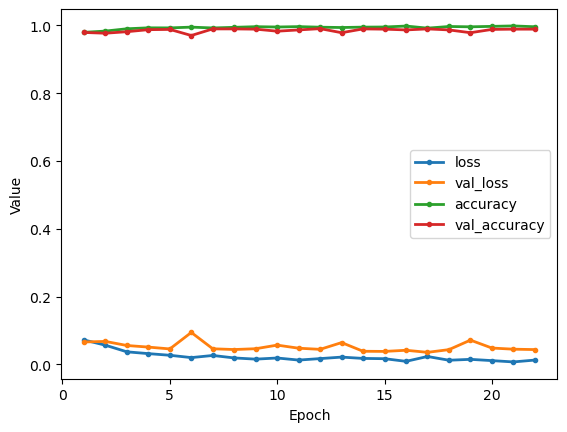

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/53 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step


 1/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
6030,0.000000,0.0,0.002439,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.004464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3983,0.004785,0.0,0.000000,0.002392,0.0,0.002392,0.002392,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488,0.000000,0.0,0.000000,0.003049,0.0,0.000000,0.000000,0.006098,0.000000,0.003049,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5556,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.003279,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (6676, 8875)
X_test: (1669, 8875)
y_train: (6676,)
y_test: (1669,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,272,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,315,521 (8.83 MB)

 Trainable params: 2,315,521 (8.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 41s 495ms/step - accuracy: 0.5000 - loss: 0.6932

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5107 - loss: 0.6926   

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5571 - loss: 0.6905

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6045 - loss: 0.6865

33/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6450 - loss: 0.6794

41/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6776 - loss: 0.6680

49/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7041 - loss: 0.6516

58/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7286 - loss: 0.6286

66/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7469 - loss: 0.6064

75/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7643 - loss: 0.5816

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7791 - loss: 0.5579

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7806 - loss: 0.5554 - val_accuracy: 0.9948 - val_loss: 0.0215


Epoch 2/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.0109

10/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0098 

19/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9991 - loss: 0.0089

27/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0084

35/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0085

44/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0086

52/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.0089

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.0091

68/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.0092

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.0092

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9985 - loss: 0.0093 - val_accuracy: 0.9933 - val_loss: 0.0226


Epoch 3/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0092

10/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0105 

18/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0098

27/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9991 - loss: 0.0087

36/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9991 - loss: 0.0079

44/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9991 - loss: 0.0073

52/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9991 - loss: 0.0069

61/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9991 - loss: 0.0066

69/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9991 - loss: 0.0063

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9991 - loss: 0.0062

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9991 - loss: 0.0061 - val_accuracy: 0.9963 - val_loss: 0.0170


Epoch 4/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 8.4975e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.1147e-04 

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - loss: 0.0012    

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0018

34/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0024

43/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0026

52/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.0027

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.0028

69/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0027

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0027

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9987 - loss: 0.0027 - val_accuracy: 0.9955 - val_loss: 0.0155


Epoch 5/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 0.0011

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0016 

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0026

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0033

34/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0034

42/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0034

50/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0033

58/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0033

66/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0033

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0033

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0032

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9994 - loss: 0.0032 - val_accuracy: 0.9955 - val_loss: 0.0192


Epoch 6/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 2.9954e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8729e-04 

18/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8351e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6981e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5712e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4953e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.0845e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 8.7706e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0011    

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0013

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9998 - loss: 0.0014 - val_accuracy: 0.9955 - val_loss: 0.0202


Epoch 7/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.6174e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8537e-04 

18/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8449e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8383e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6301e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9868e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9782e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 5.3069e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 6.2680e-04

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 6.9278e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9999 - loss: 7.3758e-04 - val_accuracy: 0.9955 - val_loss: 0.0207


Epoch 8/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 1.2348e-04

10/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4880e-04 

18/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6222e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6949e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7571e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7711e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7742e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7656e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7500e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7413e-04

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7438e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.7994e-04 - val_accuracy: 0.9948 - val_loss: 0.0227


Epoch 9/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 1.0000 - loss: 7.8779e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 8.4516e-04

13/84 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 8.6006e-04 

21/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.4661e-04

30/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4018e-04

38/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7591e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3156e-04

55/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9040e-04

63/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.5955e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3316e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1032e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.9511e-04 - val_accuracy: 0.9963 - val_loss: 0.0221


Epoch 10/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.1466e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.4304e-05 

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.1172e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.6409e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4251e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.6505e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.8422e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.8991e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.8792e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.8204e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.7308e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 6.6999e-05 - val_accuracy: 0.9970 - val_loss: 0.0244


Epoch 11/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 7.5470e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5962e-05 

19/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.0128e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4847e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.1559e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.9277e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7515e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6893e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6485e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6061e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.5745e-05 - val_accuracy: 0.9970 - val_loss: 0.0239


Epoch 12/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 2.1108e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5359e-05 

18/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6788e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8150e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0538e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1273e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1324e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1326e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1219e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1008e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.0782e-05 - val_accuracy: 0.9970 - val_loss: 0.0254


Epoch 13/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 2.8168e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5621e-05 

18/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4756e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5151e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4749e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4397e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6609e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8885e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0340e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1105e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.1695e-05 - val_accuracy: 0.9963 - val_loss: 0.0238


Epoch 14/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 8.8065e-06

10/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1330e-05 

19/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1316e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0688e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0284e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9974e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9944e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0479e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0729e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0857e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.0901e-05 - val_accuracy: 0.9970 - val_loss: 0.0254


Epoch 15/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.5955e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7953e-05 

19/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7420e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6119e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5276e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4547e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3665e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2933e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2178e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1596e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.1278e-05 - val_accuracy: 0.9970 - val_loss: 0.0258


Epoch 16/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 5.8518e-06

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5175e-05 

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4318e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4012e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4262e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4093e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3854e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3620e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3429e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3201e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2966e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.2884e-05 - val_accuracy: 0.9970 - val_loss: 0.0263


Epoch 17/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 2.1005e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4219e-05 

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1454e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0432e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.9188e-06

41/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.7363e-06

49/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.7306e-06

57/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0513e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1024e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1331e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1682e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.1717e-05 - val_accuracy: 0.9970 - val_loss: 0.0273


Epoch 18/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 2.5514e-06

10/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.1132e-06 

18/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.4915e-06

27/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.8759e-06

36/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.9621e-06

44/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.8831e-06

52/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.7451e-06

61/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.8063e-06

69/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.8490e-06

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.8683e-06

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 8.8622e-06 - val_accuracy: 0.9970 - val_loss: 0.0269


Epoch 19/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 5.9318e-06

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.2140e-06 

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.6968e-06

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.7374e-06

33/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.3325e-06

41/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.9738e-06

49/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.6501e-06

57/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.4920e-06

65/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.4128e-06

73/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.3014e-06

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.2648e-06

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 8.2413e-06 - val_accuracy: 0.9970 - val_loss: 0.0273


Epoch 20/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.6783e-06

10/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.3304e-06 

18/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.5447e-06

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.2764e-06

34/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.4905e-06

42/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5466e-06

51/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5611e-06

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5725e-06

68/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5465e-06

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.4894e-06

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 6.4612e-06 - val_accuracy: 0.9970 - val_loss: 0.0288



[Train Accuracy: 100.00% - Test Accuracy: 99.70%]


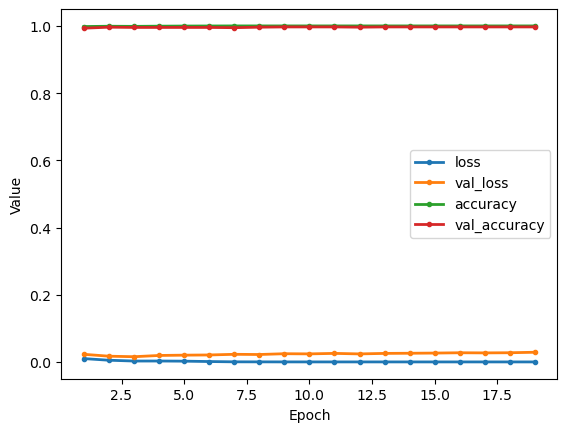

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 1/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
6030,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3983,0.002398,0.0,0.0,0.0,0.0,0.002398,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5556,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      38,345,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,387,201 (146.44 MB)

 Trainable params: 38,387,201 (146.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 57s 687ms/step - accuracy: 0.4062 - loss: 0.6932

 2/84 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.4336 - loss: 0.6931 

 3/84 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.4453 - loss: 0.6931

 4/84 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.4512 - loss: 0.6931

 5/84 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.4559 - loss: 0.6931

 6/84 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.4594 - loss: 0.6931

 7/84 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.4604 - loss: 0.6931

 8/84 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.4614 - loss: 0.6931

 9/84 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.4632 - loss: 0.6931

10/84 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.4664 - loss: 0.6930

11/84 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.4693 - loss: 0.6930

12/84 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.4723 - loss: 0.6929

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.4742 - loss: 0.6928

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.4760 - loss: 0.6928

15/84 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.4785 - loss: 0.6927

16/84 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.4816 - loss: 0.6926

17/84 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.4846 - loss: 0.6924

18/84 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.4877 - loss: 0.6923

19/84 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.4902 - loss: 0.6922

20/84 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.4928 - loss: 0.6920

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.4956 - loss: 0.6918

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.4983 - loss: 0.6917

23/84 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.5010 - loss: 0.6914

24/84 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.5038 - loss: 0.6912

25/84 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.5067 - loss: 0.6910

26/84 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.5097 - loss: 0.6907

27/84 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.5128 - loss: 0.6904

28/84 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.5159 - loss: 0.6901

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.5190 - loss: 0.6898

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.5222 - loss: 0.6895

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.5255 - loss: 0.6891

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.5290 - loss: 0.6887

33/84 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.5326 - loss: 0.6883

34/84 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.5362 - loss: 0.6878

35/84 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.5399 - loss: 0.6874

36/84 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.5436 - loss: 0.6868

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.5474 - loss: 0.6863

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.5512 - loss: 0.6857

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.5549 - loss: 0.6851

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.5586 - loss: 0.6844

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.5623 - loss: 0.6836

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.5660 - loss: 0.6828

43/84 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.5696 - loss: 0.6820

44/84 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.5733 - loss: 0.6811

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.5768 - loss: 0.6802

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.5803 - loss: 0.6792

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.5838 - loss: 0.6782

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.5873 - loss: 0.6771

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.5907 - loss: 0.6760

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.5940 - loss: 0.6748

51/84 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.5973 - loss: 0.6736

52/84 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.6006 - loss: 0.6723

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.6038 - loss: 0.6710

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.6070 - loss: 0.6696

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.6101 - loss: 0.6682

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.6132 - loss: 0.6668

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.6162 - loss: 0.6652

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.6192 - loss: 0.6637

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.6221 - loss: 0.6621

60/84 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.6250 - loss: 0.6604

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.6279 - loss: 0.6587

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.6307 - loss: 0.6569

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.6335 - loss: 0.6551

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.6362 - loss: 0.6533

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.6389 - loss: 0.6514

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.6416 - loss: 0.6495

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.6442 - loss: 0.6475

68/84 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.6468 - loss: 0.6456

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.6493 - loss: 0.6435

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.6518 - loss: 0.6415

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.6543 - loss: 0.6394

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.6567 - loss: 0.6373

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.6591 - loss: 0.6352

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.6615 - loss: 0.6331

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.6638 - loss: 0.6310

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6661 - loss: 0.6288

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6684 - loss: 0.6266

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6706 - loss: 0.6244

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6728 - loss: 0.6222

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6749 - loss: 0.6200

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.6771 - loss: 0.6178

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.6792 - loss: 0.6156

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.6812 - loss: 0.6134

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.6833 - loss: 0.6112

84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.6852 - loss: 0.6090 - val_accuracy: 0.9963 - val_loss: 0.0244


Epoch 2/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 18s 225ms/step - accuracy: 1.0000 - loss: 0.0128

 2/84 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 0.0136

 3/84 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 0.0140

 4/84 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.9990 - loss: 0.0149

 5/84 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.9986 - loss: 0.0152

 6/84 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.9980 - loss: 0.0158

 7/84 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9976 - loss: 0.0161

 8/84 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9974 - loss: 0.0163

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9973 - loss: 0.0163 

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9973 - loss: 0.0163

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9973 - loss: 0.0162

12/84 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9973 - loss: 0.0160

13/84 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9973 - loss: 0.0159

14/84 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9973 - loss: 0.0158

15/84 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9973 - loss: 0.0159

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9973 - loss: 0.0160

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9972 - loss: 0.0162

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9971 - loss: 0.0163

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9971 - loss: 0.0164

20/84 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9970 - loss: 0.0164

21/84 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9970 - loss: 0.0164

22/84 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9969 - loss: 0.0165

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9968 - loss: 0.0165

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9968 - loss: 0.0165

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9967 - loss: 0.0165

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9967 - loss: 0.0164

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9967 - loss: 0.0164

28/84 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9966 - loss: 0.0164

29/84 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9966 - loss: 0.0163

30/84 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9966 - loss: 0.0163

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9966 - loss: 0.0162

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9966 - loss: 0.0162

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9966 - loss: 0.0161

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9966 - loss: 0.0161

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9966 - loss: 0.0160

36/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9966 - loss: 0.0159

37/84 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9966 - loss: 0.0159

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9966 - loss: 0.0158

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9966 - loss: 0.0157

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9966 - loss: 0.0157

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9966 - loss: 0.0156

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9966 - loss: 0.0155

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9966 - loss: 0.0155

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9966 - loss: 0.0154

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9966 - loss: 0.0153

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9966 - loss: 0.0153

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9966 - loss: 0.0152

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9966 - loss: 0.0152

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9966 - loss: 0.0151

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9966 - loss: 0.0151

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9966 - loss: 0.0150

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9966 - loss: 0.0150

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9966 - loss: 0.0150

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9966 - loss: 0.0149

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9966 - loss: 0.0149

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9965 - loss: 0.0149

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9965 - loss: 0.0149

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9965 - loss: 0.0148

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9965 - loss: 0.0148

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9965 - loss: 0.0148

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9965 - loss: 0.0147

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9965 - loss: 0.0147

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9965 - loss: 0.0147

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9965 - loss: 0.0146

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9965 - loss: 0.0146

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9965 - loss: 0.0146

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9965 - loss: 0.0145

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9965 - loss: 0.0145

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9965 - loss: 0.0144

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9965 - loss: 0.0144

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9965 - loss: 0.0144

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9965 - loss: 0.0144

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9965 - loss: 0.0143

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9965 - loss: 0.0143

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9965 - loss: 0.0143

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9965 - loss: 0.0142

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9965 - loss: 0.0142

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9965 - loss: 0.0142

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9965 - loss: 0.0141

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9965 - loss: 0.0141

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9965 - loss: 0.0141

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9965 - loss: 0.0140

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9965 - loss: 0.0140

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9966 - loss: 0.0140

84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 0.9966 - loss: 0.0139 - val_accuracy: 0.9985 - val_loss: 0.0070


Epoch 3/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/step - accuracy: 1.0000 - loss: 0.0028

 2/84 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 0.0024

 3/84 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 0.0023

 4/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 0.0022 

 5/84 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 0.0021

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 0.0020

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 0.0020

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 0.0019

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 0.0018

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 0.0018

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 0.0018

12/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 0.0017

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 0.0017

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 0.0017

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 0.0017

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.9999 - loss: 0.0018

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.9999 - loss: 0.0018

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.9998 - loss: 0.0019

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.9998 - loss: 0.0019

20/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.9998 - loss: 0.0020

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.9998 - loss: 0.0020

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.9997 - loss: 0.0020

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.9997 - loss: 0.0020

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.9997 - loss: 0.0020

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.9997 - loss: 0.0020

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.9997 - loss: 0.0020

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.9997 - loss: 0.0021

28/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.9997 - loss: 0.0021

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.9997 - loss: 0.0021

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.9996 - loss: 0.0021

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.9996 - loss: 0.0021

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.9996 - loss: 0.0021

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.9996 - loss: 0.0021

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.9996 - loss: 0.0021

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9996 - loss: 0.0021

36/84 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9996 - loss: 0.0021

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9996 - loss: 0.0020

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9996 - loss: 0.0020

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9996 - loss: 0.0020

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9996 - loss: 0.0020

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9996 - loss: 0.0020

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9996 - loss: 0.0020

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9996 - loss: 0.0020

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9996 - loss: 0.0020

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9996 - loss: 0.0020

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9996 - loss: 0.0020

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9996 - loss: 0.0020

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9996 - loss: 0.0020

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9996 - loss: 0.0020

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9996 - loss: 0.0020

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9996 - loss: 0.0020

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9996 - loss: 0.0020

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9996 - loss: 0.0020

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9996 - loss: 0.0020

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9996 - loss: 0.0020

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9996 - loss: 0.0020

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9996 - loss: 0.0020

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9996 - loss: 0.0020

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9996 - loss: 0.0020

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9996 - loss: 0.0020

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9996 - loss: 0.0020

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9996 - loss: 0.0020

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9996 - loss: 0.0020

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9996 - loss: 0.0020

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9996 - loss: 0.0020

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9996 - loss: 0.0020

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9996 - loss: 0.0020

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9996 - loss: 0.0020

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9996 - loss: 0.0020

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9996 - loss: 0.0020

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9996 - loss: 0.0020

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9996 - loss: 0.0020

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9996 - loss: 0.0020

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9996 - loss: 0.0020

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9996 - loss: 0.0020

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9996 - loss: 0.0020

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9996 - loss: 0.0020

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9996 - loss: 0.0020

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9996 - loss: 0.0020

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9996 - loss: 0.0020

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9996 - loss: 0.0020

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9996 - loss: 0.0020

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9996 - loss: 0.0020

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9996 - loss: 0.0020

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 0.9978 - val_loss: 0.0100


Epoch 4/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 26s 320ms/step - accuracy: 1.0000 - loss: 3.0712e-04

 2/84 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 1.0000 - loss: 3.3944e-04 

 3/84 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 1.0000 - loss: 3.4717e-04

 4/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 3.4957e-04

 5/84 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 1.0000 - loss: 3.5027e-04

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 1.0000 - loss: 3.5028e-04

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 3.4892e-04

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 3.4643e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 3.4457e-04

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 3.4509e-04

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 3.4470e-04

12/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 3.4332e-04

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 3.4168e-04

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 3.3978e-04

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 3.3745e-04

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 3.3636e-04

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 3.3587e-04

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 3.3517e-04

19/84 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 3.3398e-04

20/84 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 3.3292e-04

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 3.3198e-04

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 3.3132e-04

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 3.3044e-04

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 3.2948e-04

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 3.2850e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 3.2752e-04

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 3.2650e-04

28/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 3.2536e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 3.2421e-04

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 3.2307e-04

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 3.2198e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 3.2101e-04

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 3.2001e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 3.1916e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 3.1822e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 3.1729e-04

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 3.1634e-04

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 3.1541e-04

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 3.1952e-04

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 3.2328e-04

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 3.2668e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 3.2993e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 3.3294e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 3.3563e-04

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 3.3816e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 3.4059e-04

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 3.4280e-04

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 3.4483e-04

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 3.4669e-04

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 3.4839e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 3.4996e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.5142e-04

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.5279e-04

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.5409e-04

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.5552e-04

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.5682e-04

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.5812e-04

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.5935e-04

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.6049e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.6154e-04

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.6262e-04

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.6367e-04

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.6466e-04

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 3.6557e-04

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 3.6640e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 3.6717e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 3.6787e-04

68/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 3.6855e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 3.6926e-04

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 3.7076e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 3.7226e-04

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 3.7375e-04

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 3.7517e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.7651e-04

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.7777e-04

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 3.7897e-04

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 3.8014e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 3.8125e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 3.8232e-04

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 3.8332e-04

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 3.8426e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 3.8514e-04

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 3.8597e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 3.8676e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 3.8753e-04 - val_accuracy: 0.9978 - val_loss: 0.0075


Epoch 5/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 18s 220ms/step - accuracy: 1.0000 - loss: 5.3607e-04

 2/84 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 4.3984e-04

 3/84 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 4.0208e-04

 4/84 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 3.7749e-04

 5/84 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.5777e-04

 6/84 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 3.4890e-04

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 3.4281e-04 

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 3.4160e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.4082e-04

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.3869e-04

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 3.3700e-04

12/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 3.3492e-04

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 3.3311e-04

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 3.3189e-04

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 3.3023e-04

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 3.2850e-04

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 3.2701e-04

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 3.2573e-04

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 3.2426e-04

20/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 3.2261e-04

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 3.2091e-04

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 3.1927e-04

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.1739e-04

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.1577e-04

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.1447e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.1313e-04

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.1175e-04

28/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.1032e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.0881e-04

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.0721e-04

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 3.0558e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 3.0393e-04

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 3.0227e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 3.0061e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 2.9915e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.9774e-04

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.9635e-04

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.9492e-04

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.9351e-04

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.9307e-04

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 2.9255e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 2.9199e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 2.9135e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.9069e-04

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.9001e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.8928e-04

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.8856e-04

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.8784e-04

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.8781e-04

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.8776e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.8764e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 2.8748e-04

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 2.8728e-04

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 2.8706e-04

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 2.8680e-04

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 2.8652e-04

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 2.8636e-04

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 2.8617e-04

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 2.8592e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.8577e-04

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.8558e-04

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.8536e-04

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.8514e-04

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.8488e-04

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.8459e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.8428e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.8396e-04

68/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.8363e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.8328e-04

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.8291e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.8254e-04

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.8215e-04

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.8174e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 2.8133e-04

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.8090e-04

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.8046e-04

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.8005e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.7964e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.7920e-04

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.7876e-04

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.7831e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.7786e-04

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.7740e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.7695e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 2.7651e-04 - val_accuracy: 0.9970 - val_loss: 0.0120


Epoch 6/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 17s 213ms/step - accuracy: 1.0000 - loss: 4.5511e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 5.0313e-05

 3/84 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 1.0000 - loss: 5.7765e-05 

 4/84 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 1.0000 - loss: 6.2353e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 6.3934e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 1.0000 - loss: 6.8411e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 7.2925e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 7.6401e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 8.0229e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 8.3299e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 8.5646e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 8.7324e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 8.8797e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 8.9790e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 9.0497e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 9.0922e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 9.2001e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 9.2997e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 9.3790e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 9.4400e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 9.4867e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 9.5309e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 9.6217e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 9.7042e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 9.7778e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 9.8384e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 9.8956e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.0096e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.0276e-04

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 1.0440e-04

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.0586e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.0717e-04

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.0865e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.0998e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.1116e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.1224e-04

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.1326e-04

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.1425e-04

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.1517e-04

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.1603e-04

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.1680e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.1750e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.1815e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.1873e-04

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.1930e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.1985e-04

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.2033e-04

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.2085e-04

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.2133e-04

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.2176e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.2215e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.2254e-04

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.2290e-04

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.2324e-04

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.2355e-04

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.2384e-04

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.2409e-04

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.2431e-04

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.2459e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.2486e-04

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.2512e-04

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.2538e-04

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.2561e-04

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.2584e-04

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.2606e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.2626e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.2646e-04

68/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.2663e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.2678e-04

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.2691e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.2702e-04

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.2712e-04

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.2720e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.2729e-04

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.2738e-04

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.2747e-04

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.2754e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.2760e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.2765e-04

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.2771e-04

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.2775e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.2779e-04

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.2783e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.2787e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 1.2791e-04 - val_accuracy: 0.9978 - val_loss: 0.0111


Epoch 7/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 17s 205ms/step - accuracy: 1.0000 - loss: 8.4035e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 1.0000 - loss: 1.9883e-04 

 3/84 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 2.2240e-04

 4/84 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.2171e-04

 5/84 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.1896e-04 

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.1276e-04

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 2.0704e-04

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 2.0150e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.9590e-04

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 1.9227e-04

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 1.8861e-04

12/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.8691e-04

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 1.8490e-04

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.8352e-04

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 1.8189e-04

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 1.8034e-04

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.7877e-04

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.7707e-04

19/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.7554e-04

20/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.7386e-04

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.7235e-04

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.7093e-04

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.6944e-04

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.6794e-04

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.6648e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.6505e-04

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.6374e-04

28/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.6254e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.6162e-04

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.6104e-04

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.6048e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.5991e-04

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.5932e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.5873e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.5815e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.5761e-04

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.5703e-04

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.5643e-04

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.5582e-04

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.5520e-04

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.5468e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.5412e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.5392e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.5368e-04

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.5342e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.5313e-04

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.5283e-04

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.5250e-04

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.5218e-04

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.5184e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.5148e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.5110e-04

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.5073e-04

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.5035e-04

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.4996e-04

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.4956e-04

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.4916e-04

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.4876e-04

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.4834e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.4793e-04

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.4751e-04

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.4710e-04

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.4669e-04

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.4627e-04

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.4584e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.4542e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.4500e-04

68/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.4463e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.4427e-04

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.4391e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.4354e-04

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.4317e-04

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.4279e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.4241e-04

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.4202e-04

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.4165e-04

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.4126e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.4088e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.4053e-04

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.4017e-04

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.3982e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.3947e-04

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.3912e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.3877e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 1.3843e-04 - val_accuracy: 0.9970 - val_loss: 0.0125


Epoch 8/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 22s 269ms/step - accuracy: 1.0000 - loss: 5.6776e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 5.0802e-05

 3/84 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 4.9537e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 4.7881e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 4.7782e-05 

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 4.7924e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 4.7946e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 4.7866e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 4.8081e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 4.8640e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 4.9227e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 4.9804e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 5.0226e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 5.1288e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 5.2102e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 5.2974e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 5.3581e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 5.4139e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 5.4526e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 5.4918e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.5253e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 5.5489e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.5708e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.5881e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.6031e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.6163e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.6287e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 5.6447e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 5.6713e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 5.6935e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 5.7158e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 5.7351e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 5.7726e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 5.8152e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 5.8536e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 5.8900e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 5.9207e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 5.9544e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 5.9875e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 6.0165e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 6.0427e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 6.0652e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 6.0915e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 6.1150e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 6.1352e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 6.1563e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 6.1759e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 6.1939e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 6.2103e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 6.2245e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 6.2379e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 6.2514e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 6.2639e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 6.2747e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 6.2849e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 6.2937e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 6.3035e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 6.3119e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 6.3208e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 6.3288e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 6.3353e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 6.3414e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 6.3541e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 6.3659e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 6.3767e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 6.3865e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 6.3957e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 6.4048e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 6.4138e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 6.4227e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 6.4307e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 6.4435e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 6.4550e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 6.4663e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 6.4767e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.4863e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.4952e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.5036e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.5113e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 6.5184e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 6.5246e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 6.5306e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 6.5359e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 6.5409e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 6.5457e-05 - val_accuracy: 0.9970 - val_loss: 0.0123


Epoch 9/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 26s 317ms/step - accuracy: 1.0000 - loss: 5.2982e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 4.9289e-05

 3/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 4.9729e-05 

 4/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 5.0361e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 5.0602e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 5.1998e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 5.2966e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 5.3453e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 5.3557e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 5.3322e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 5.2905e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 5.2451e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 5.1909e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 5.1334e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 5.0770e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 5.0186e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 4.9807e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 4.9413e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 4.9036e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 4.8687e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 4.8437e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.8250e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 4.8044e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.7851e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.7682e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.7527e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 4.7616e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 4.7687e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 4.7779e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 4.7858e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 4.7942e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 4.8009e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.8108e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.8214e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.8333e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.8435e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.8615e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.8755e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.8888e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.9009e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.9131e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.9231e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.9314e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 4.9385e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 4.9443e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 4.9493e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 4.9529e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 4.9556e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 4.9571e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 4.9583e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 4.9587e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.9589e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 4.9597e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 4.9604e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 4.9606e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.9597e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 4.9587e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 4.9576e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 4.9565e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.9548e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.9547e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.9570e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.9589e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.9604e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.9613e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.9615e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.9611e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.9615e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.9615e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.9616e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.9614e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.9611e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.9605e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.9595e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 4.9586e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.9577e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.9647e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.9740e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.9830e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.9920e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 5.0003e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 5.0081e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 5.0153e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 5.0222e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 5.0288e-05 - val_accuracy: 0.9978 - val_loss: 0.0120


Epoch 10/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 16s 199ms/step - accuracy: 1.0000 - loss: 3.2833e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 1.0000 - loss: 5.1023e-05 

 3/84 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 1.0000 - loss: 5.0806e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 1.0000 - loss: 4.9031e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 1.0000 - loss: 4.8220e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 1.0000 - loss: 4.9154e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 4.9552e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 4.9803e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 4.9773e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 4.9542e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 4.9291e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 4.9289e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 4.9377e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 4.9320e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 4.9420e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 4.9429e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 4.9414e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 4.9399e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 4.9335e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 4.9210e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 4.9075e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.9024e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.9039e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.9004e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 4.8954e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.8887e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.8804e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.8730e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.8643e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.8537e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.8414e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 4.8295e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 4.8303e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 4.8279e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 4.8274e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 4.8269e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 4.8251e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 4.8219e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 4.8181e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 4.8129e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 4.8079e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 4.8031e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 4.7978e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 4.7931e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 4.7872e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 4.7808e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 4.7740e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 4.7667e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 4.7607e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 4.7539e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 4.7472e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 4.7421e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 4.7365e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 4.7306e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 4.7254e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 4.7200e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 4.7148e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 4.7103e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 4.7064e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 4.7031e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 4.6993e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 4.6960e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 4.6931e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 4.6912e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 4.6912e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 4.6943e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 4.6972e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 4.6997e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 4.7034e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 4.7076e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 4.7113e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 4.7151e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 4.7183e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 4.7212e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 4.7234e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 4.7251e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 4.7263e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.7271e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.7276e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.7276e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.7277e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 4.7279e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 4.7277e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 4.7273e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 4.7270e-05 - val_accuracy: 0.9970 - val_loss: 0.0123


Epoch 11/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 17s 207ms/step - accuracy: 1.0000 - loss: 3.1598e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.0937e-05

 3/84 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 2.9192e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 2.7710e-05 

 5/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 2.7100e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 2.6522e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 2.6763e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.7982e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 2.8671e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.9192e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.9842e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.0508e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 3.1454e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 3.2225e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 3.2923e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 3.3527e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 3.4001e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 3.4395e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 3.4742e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.5206e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.5586e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.5891e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.6302e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.6665e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.6980e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.7236e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.7461e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 3.7669e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 3.7835e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.7975e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.8105e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.8214e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.8308e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.8372e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.8415e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 3.8472e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.8521e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.8561e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.8586e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.8610e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.8628e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.8633e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.8632e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.8628e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.8637e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.8653e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.8655e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.8654e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.8647e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.8638e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.8624e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.8604e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.8580e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.8559e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.8541e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.8519e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.8493e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.8463e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.8431e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 3.8422e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.8411e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.8399e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.8385e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.8401e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.8414e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.8421e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 3.8427e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 3.8431e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 3.8431e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 3.8427e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 3.8419e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 3.8409e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 3.8397e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 3.8386e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 3.8372e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 3.8355e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 3.8342e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 3.8327e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 3.8341e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 3.8350e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 3.8362e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 3.8370e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 3.8374e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 3.8377e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 3.8380e-05 - val_accuracy: 0.9978 - val_loss: 0.0121


Epoch 12/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 18s 227ms/step - accuracy: 1.0000 - loss: 2.9280e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 4.7370e-05

 3/84 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 1.0000 - loss: 5.0053e-05 

 4/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 4.9161e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 4.9167e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 4.8366e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 1.0000 - loss: 4.7163e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 4.5852e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 4.4800e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 4.3739e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 1.0000 - loss: 4.2965e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 4.2344e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 4.1886e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 4.1561e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 4.1289e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 4.0970e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 4.0622e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 4.0325e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 4.0013e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 3.9772e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 3.9768e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 3.9724e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 3.9648e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 3.9648e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 3.9610e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 3.9588e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 3.9537e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 3.9492e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 3.9427e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 3.9360e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 3.9282e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 3.9193e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 3.9114e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 3.9036e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 3.8970e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 3.8901e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 3.8853e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 3.8789e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 3.8722e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 3.8648e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 3.8585e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 3.8517e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 3.8449e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 3.8373e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 3.8291e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 3.8203e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 3.8108e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 3.8016e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 3.7956e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 3.7895e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 3.7832e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 3.7767e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 3.7704e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.7640e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.7603e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.7566e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.7526e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.7485e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.7438e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.7391e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.7344e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.7294e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.7243e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.7187e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.7131e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.7079e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.7025e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.6968e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.6909e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.6847e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.6784e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.6720e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.6655e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.6592e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.6529e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 3.6473e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 3.6418e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 3.6363e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 3.6308e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 3.6252e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 3.6195e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 3.6138e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 3.6081e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 3.6026e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 3.5973e-05 - val_accuracy: 0.9970 - val_loss: 0.0125



[Train Accuracy: 100.00% - Test Accuracy: 99.70%]


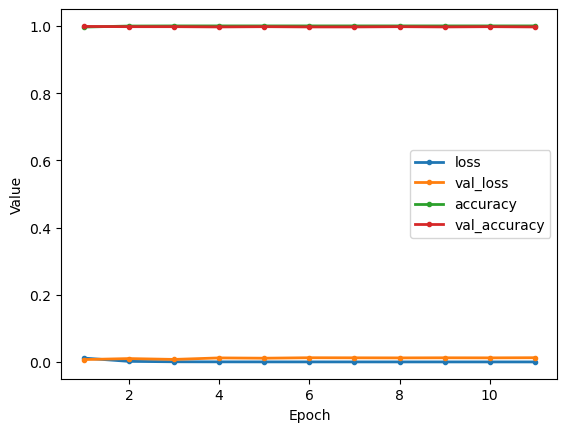

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/53 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step

 6/53 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

12/53 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

18/53 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

23/53 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

33/53 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

38/53 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

44/53 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


 1/53 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step

 6/53 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

11/53 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/53 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

21/53 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

26/53 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

31/53 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

37/53 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

42/53 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [25]:
report.save()

Report saved as Output/Reports/TCP/report_BT29T4ME.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################